In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

    Note: run in megabouts_dlc

In [27]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import tables
import flammkuchen as fl

# Computation
from scipy.interpolate import interp1d

#custom functions
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.signal.signaltools import correlate

from tqdm import tqdm

In [28]:
def nanzscore(array, axis=0):
    return (array - np.nanmean(array, axis=axis))/np.nanstd(array, axis=axis)

def reduce_to_pi(ar):
    """Reduce angles to the -pi to pi range"""
    return np.mod(ar + np.pi, np.pi * 2) - np.pi

def compute_tailsum(tail_angle):
    pre_tailsum= np.zeros((tail_angle.shape[0], tail_angle.shape[1]))
    for segment in range(tail_angle.shape[1]):
        pre_tailsum[:,segment]= (tail_angle[:, segment] - tail_angle[:,0])

    tailsum= np.sum(pre_tailsum, axis=1)/pre_tailsum.shape[1]
    tailsum = reduce_to_pi(tailsum)
    return tailsum

def moving_average(x, w):
    return np.hstack(([0,0], np.convolve(x, np.ones(w), 'valid') / w))

In [29]:
def get_motor_pos(df_dlc):
    motor_x = df_dlc.motor.x.values.astype('float')
    motor_y = df_dlc.motor.y.values.astype('float')
    motor_z = df_dlc.motor.z.values.astype('float')
    return motor_x, motor_y, motor_z


def get_eye_data(data):
    left_eye_angle = data['eye_angles'][0]
    right_eye_angle = data['eye_angles'][1]
    eye_rot = data['rotation']
    eye_vergence = data['vergence']
    return left_eye_angle, right_eye_angle, eye_rot, eye_vergence

def create_buffer_lists():
    cluster_n_vector =[]
    body_angles_delta= []
    eye_angles_vector= []
    fin_angles_vector= []
    tail_vectors =[]
    tailsums = []
    body_angles =[]
    eye_vergence_vect =[]
    eye_rot_vect =[]
    
    bout_times = []
    motor_values = []
    mb_outlier =[]
    mb_proba = []
    dlc_filter =[]
    edge_filter =[]
    
    return cluster_n_vector,body_angles_delta,eye_angles_vector,fin_angles_vector,tail_vectors,tailsums ,body_angles,eye_vergence_vect,eye_rot_vect,bout_times ,motor_values ,mb_outlier,mb_proba ,dlc_filter,edge_filter


# Set up paths

In [30]:
# master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

# fish_paths = list(master_path.glob('*f[0-9]*'))
# fish_paths, len(fish_paths)

In [71]:
## Analysed for paper

# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\230307_visstim_2D") #rectangular arena # start from fish 1
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_round")
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\22042024_visstim_2D_2") #rectangular arena
# master_path = Path(r"\\portulab.synology.me\data\Kata\Data\13052024_visstim_2D_round")
master_path = Path(r"\\portulab.synology.me\data\Kata\Data\14052024_visstim_2D_round")

In [72]:
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths, len(fish_paths)

([WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f0'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f1'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f2'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f3'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f4'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f5'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f6'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f7'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f8'),
  WindowsPath('//portulab.synology.me/data/Kata/Data/14052024_visstim_2D_round/240514_f9')],
 10)

In [73]:
# out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')

In [74]:
## Analysed for paper

# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\230307_visstim_2D_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_round_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_2_")
# out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\13052024_visstim_2D_round_")
out_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\14052024_visstim_2D_round_")

In [75]:
fish= 0
fish_id =  fish_paths[fish].name#[:-13]
exp_name = Path(fish_paths[fish]).parts[-2]
# exp_name = 'testfish'
exp_name, fish_id

('14052024_visstim_2D_round', '240514_f0')

In [76]:
print ("{} videos found".format(len(fish_paths)))

10 videos found


In [77]:
## define time window for bout cropping
bout_duration = 50
pre_bout = 5

## Loop

In [78]:

for ind, fish_path in enumerate(tqdm(fish_paths)):
    fish_id =  fish_path.name
    print ('Working on fish {}'.format(fish_id))

    dlc_path_ = Path(out_path/ '{}_DLC_mod.csv'.format(fish_id)) 
    df_dlc = pd.read_csv(dlc_path_, header=[0,1])
    motor_x, motor_y, motor_z = get_motor_pos(df_dlc)
    dlc_filter_ = df_dlc.DLC_filter.pos.values
    edge_filter_ = df_dlc.edge_filter.ok.values

    data = fl.load(Path(out_path/ '{}_megabouts_res.h5'.format(fish_id)))
    print('working with {} detected bouts'.format(len(data['segments_on'])))

    left_eye_angle, right_eye_angle, eye_rot, eye_vergence = get_eye_data(data)

    #unpack data 
    left_fin_angle = data['fin_angles'][0]
    right_fin_angle = data['fin_angles'][1]
    cluster_n_vector,body_angles_delta,eye_angles_vector,fin_angles_vector,tail_vectors,tailsums ,body_angles,eye_vergence_vect,eye_rot_vect,bout_times ,motor_values ,mb_outlier,mb_proba ,dlc_filter,edge_filter = create_buffer_lists()
    lats_ =[]
    
    for i, on_ in enumerate(data['segments_on']):
            if on_+bout_duration<data['body_angle'].shape[0]:
                on_ = on_ - pre_bout
                body_angle_delta = np.array(data['body_angle'][on_+bout_duration]-data['body_angle'][on_])*180/np.pi
                body_angles_delta.append(body_angle_delta)
                body_angles.append(data['body_angle'][on_: on_ + bout_duration] - data['body_angle'][on_])
                
                left_eye = left_eye_angle[on_ :on_+bout_duration]  -left_eye_angle[on_] 
                right_eye = right_eye_angle[on_ :on_+bout_duration] - right_eye_angle[on_]
                eye_angles_vector.append([left_eye, right_eye])
                
                left_fin = left_fin_angle[on_ :on_+bout_duration] -left_fin_angle[on_] 
                right_fin = right_fin_angle[on_ :on_+bout_duration]- right_fin_angle[on_]
                fin_angles_vector.append([left_fin, right_fin])
                eye_vergence_vect.append(eye_vergence[on_: on_ + bout_duration])
                eye_rot_vect.append(eye_rot[on_: on_ + bout_duration])
        
                cluster_n_vector.append(data['cluster_n_vector'][on_+pre_bout])
                tail_vectors.append(data['clean_data_tail'][:,:10][on_: on_ + bout_duration])
                tailsums.append(compute_tailsum(data['clean_data_tail'][:,:10][on_: on_ + bout_duration]))
    
                motor_values.append([motor_x[on_ :on_+bout_duration], motor_y[on_ :on_+bout_duration], motor_z[on_ :on_+bout_duration]])
    
                mb_proba.append(data['proba'][i])
                dlc_filter.append(dlc_filter_[on_+pre_bout])
                edge_filter.append(edge_filter_[on_+pre_bout])
                lats_.append(data['laterality'][i])
                bout_times.append([data['segments_on'][i], data['segments_off'][i]])

    
    data_to_save = dict({
        'tailsums': np.asarray(tailsums),
        'tail_vectors' : np.asarray(tail_vectors),
        'body_angles_delta': np.asarray(body_angles_delta),
        'body_angles' : np.asarray(body_angles),
    
        'eye_angles' : np.asarray(eye_angles_vector),
        'fin_angles' : np.asarray(fin_angles_vector),
        'eye_rotation': np.asarray(eye_rot_vect),
        'eye_vergence': np.asarray(eye_vergence_vect),
    
        'cluster': np.asarray(cluster_n_vector),
    
        'motor' : np.asarray(motor_values),
        'mb_proba' : np.asarray(mb_proba),
        'dlc_filter' : np.asarray(dlc_filter),
        'edge_filter' : np.asarray(edge_filter),
        'bout_times' : np.asarray(bout_times),
        'laterality' : np.asarray(lats_),
    
    })
    
    fl.save(out_path/'{}_bout_data.h5'.format(fish_id), data_to_save)





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Working on fish 240514_f0
working with 508 detected bouts


 10%|████████▎                                                                          | 1/10 [00:02<00:24,  2.69s/it]

Working on fish 240514_f1
working with 426 detected bouts


 20%|████████████████▌                                                                  | 2/10 [00:05<00:21,  2.72s/it]

Working on fish 240514_f2


 30%|████████████████████████▉                                                          | 3/10 [00:07<00:17,  2.43s/it]

working with 122 detected bouts
Working on fish 240514_f3
working with 595 detected bouts


 40%|█████████████████████████████████▏                                                 | 4/10 [00:10<00:15,  2.66s/it]

Working on fish 240514_f4
working with 300 detected bouts


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:13<00:12,  2.60s/it]

Working on fish 240514_f5
working with 323 detected bouts


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:15<00:10,  2.64s/it]

Working on fish 240514_f6
working with 314 detected bouts


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:18<00:07,  2.58s/it]

Working on fish 240514_f7
working with 330 detected bouts


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:20<00:05,  2.53s/it]

Working on fish 240514_f8
working with 618 detected bouts


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:23<00:02,  2.58s/it]

Working on fish 240514_f9
working with 632 detected bouts


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.60s/it]


### check extracted data

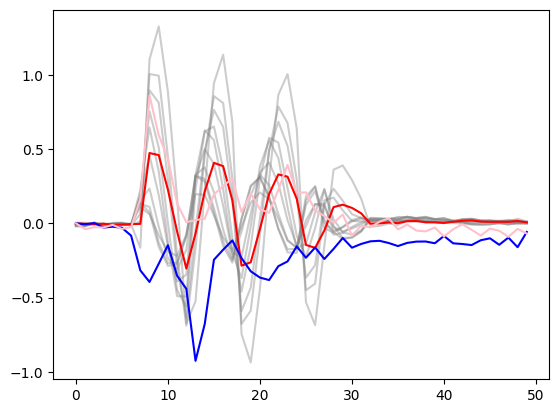

In [79]:
# Generate a random integer from 0 to num_elements - 1
bout = np.random.randint(0, np.asarray(tailsums).shape[0])
plt.figure()
plt.plot(np.asarray(tail_vectors)[bout, :, :10], c='gray', alpha=0.4)
plt.plot(np.asarray(tailsums)[bout], c='r')
plt.plot(np.asarray(fin_angles_vector)[bout, 0,:], c='blue')
plt.plot(np.asarray(fin_angles_vector)[bout, 1,:], c='pink')